# DL Assignment 2 - Convolutional Neural Networks

This is the second **graded assignment** of the DL course. In the last labs we were discussing the task of image classification. You implemented neural networks in Numpy, designed and trained a ConvNet from scratch in TensorFlow Keras, added regularization techniques, and used pre-trained models for feature extraction and fine-tuning. Next, you explored different ways to visualize what a ConvNet has learned and which information it consumes in order to make a prediction.

In **Assigment 2** you will use these skills to train **Convolutional Neural Networks** to **predict attributes** in images of bees. Using class activation mapping, you will also map the predicted attributes to the associated image regions.

***

**After completing this assignment, you will have**
- implemented a pre-trained model for **feature extraction** from images.
- implemented a model to perform **attribute prediction** on features.
- implemented a ConvNet to perform **attribute prediction** on images.
- implemented **class activation mapping** to interprete the output of your ConvNet.

**MUCH SUCCESS!**

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>", or marked by "<font color='green'>`# TODO`</font>", denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.

***

<font color='red'>
  
**Note**  
You have to develop and submit your own solution. If we have reasons to believe you shared or did not submit your own work, we have to consider an attempted fraud. In this case your submission will be graded zero points and we reserve additional measures.
</font>

# 0 - Preparations

## 0.1 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [ ]:
#@title ### Print TF version and GPU stats
import tensorflow as tf
import sys
import numpy as np

print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.9.2
Found GPU at: /device:GPU:0

Fri Nov 25 03:29:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    312MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

## 0.2 - Download and Import `utils`

Some utility methods are again provided in a `utils` module. Execute the cell below to download the `utils.py` and import the `utils` module.

In [ ]:
!wget https://cloud.tu-ilmenau.de/s/yQsoRPRb6gGj4eQ/download/utils.py

import utils

--2022-11-25 03:29:28--  https://cloud.tu-ilmenau.de/s/yQsoRPRb6gGj4eQ/download/utils.py
Resolving cloud.tu-ilmenau.de (cloud.tu-ilmenau.de)... 141.24.186.192
Connecting to cloud.tu-ilmenau.de (cloud.tu-ilmenau.de)|141.24.186.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7116 (6.9K) [text/x-python]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.95K  --.-KB/s    in 0.006s  

2022-11-25 03:29:29 (1.20 MB/s) - ‘utils.py’ saved [7116/7116]



# 1 - The Dataset

You will use the `bee_dataset` available via the `tensorflow_datasets` module. Execute the cell below to load the dataset and print associated information.

In [ ]:
train_ds, val_ds, test_ds = utils.load_dataset()

utils.print_sample_information(train_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7490 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0.incomplete8VX85T/bee_dataset-train.tfrecord*…

Dataset bee_dataset downloaded and prepared to ~/tensorflow_datasets/bee_dataset/bee_dataset_300/1.0.0. Subsequent calls will reuse this data.

Loaded train split with 5618 samples
Loaded validation split with 1123 samples
Loaded test split with 749 samples

Input shape: (300, 150, 3)
Input data type: <dtype: 'uint8'>
Number of attributes: 4
List of attributes: ['cooling_output', 'pollen_output', 'varroa_output', 'wasps_output']


The dataset has been split into **training** (75%), **validation** (15%), and **test** (10%) data. 
Each split is provided as [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
You can see that the input images have a shape of `(300, 150, 3)` px. The images of the bees are taken from above and rotated. The bee is vertical and either its head or the trunk is on top. All images were taken with a green background and the distance to the bees was always the same, thus all bees have the same size.

All images have **four attributes**:
- **cooling_output** - Indicating that the bee is currently cooling the hive. The bee is flapping its wings while keeping its position stationary, that way it transports fresh air into the hive.
- **pollen_output** - Indicates that the bee carries a pollen packet
- **varroa_output** - Indicates that the bee is infested with the varroa mite. The varroa mite is a small circular pest which is 1-2mm in diameter and of brown color. The mite will be carried into the hive, where it seriously damages the bee larva. If left untreated, the whole colony dies.
- **wasps_output** - Instead of a bee, a wasp was captured.

This dataset is designed as multi-label dataset, where each label, e.g. *varroa_output*, contains `1` if the characteristic was present in the image and `0` if it wasn't. 

**Important:** Each image can have multiple labels assigned to it. E.g., a bee can be cooling the hive, carry a pollen packet, and have a varrio-mite infection **at the same time**.

Let's plot some of the samples:

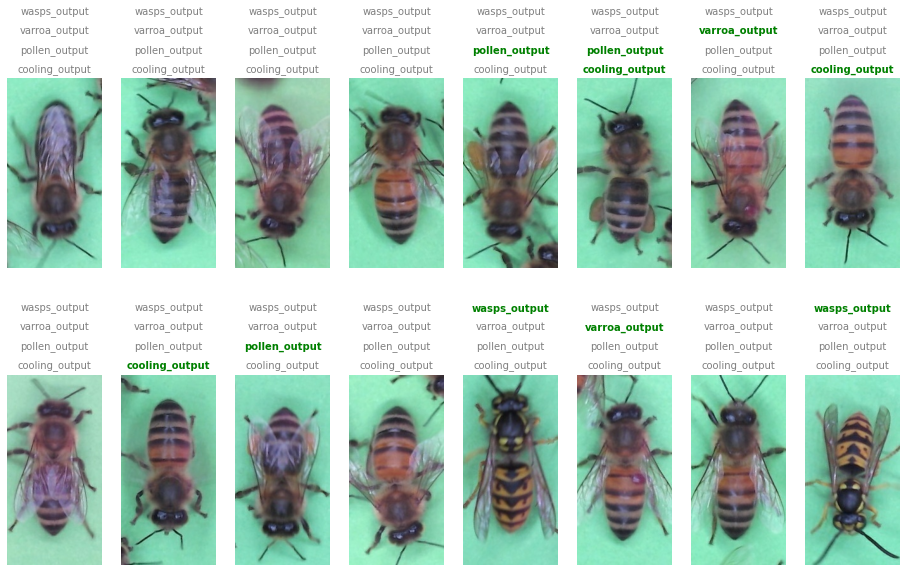

In [ ]:
utils.plot_samples(train_ds, num_samples=16)

We define some global variables that you will reuse throughout this notebook:

In [ ]:
# input image shape
INPUT_SHAPE = (300, 150, 3)

# list of attributes to be prediced
ATTRIBUTES = [
    'cooling_output', 
    'pollen_output', 
    'varroa_output', 
    'wasps_output'
]

# number of attributes
NUMBER_OF_ATTRIBUTES = len(ATTRIBUTES)

# batch size
BATCH_SIZE = 64

In addition to these variables, you need to think about
- the activation function for the output of your neural networks for attribute prediction, and
- the loss function for training your neural networks.

**Task**: Define the correct `OUTPUT_ACTIVATION` function and `LOSS_FUNCTION` for the **multi-label** attribute prediction task.

**Note**: You can either define them as string or as the corresponding class in `tf.keras`.

In [ ]:
# GRADED: OUTPUT_ACTIVATION (1 point)
# GRADED: LOSS_FUNCTION (1 point)

### START YOUR CODE HERE ### (2 LOC)

# output activation function
OUTPUT_ACTIVATION = tf.keras.activations.sigmoid

# loss function
LOSS_FUNCTION = tf.keras.losses.binary_crossentropy

### END YOUR CODE HERE ###

At last, let us preprocess all splits so that we can immediately used them for training and evaluation. The preprocessing will 
- normalize the image data,
- flatten the attributes to a vector,
- remove images without positive labels from the training,
- shuffle the samples,
- and create batches.

In [ ]:
train_ds = utils.prepare_data_for_training(train_ds, batch_size=BATCH_SIZE, train=True)
val_ds = utils.prepare_data_for_training(val_ds, batch_size=BATCH_SIZE)
test_ds = utils.prepare_data_for_training(test_ds, batch_size=BATCH_SIZE)

# 2 - On Image Agumentation

Instead of using the `ImageDataGenerator` class the datasplits are loaded as `tf.data.Dataset`. `Dataset` usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

There are (at least) two ways to incorporate **data augmentation** for a `Dataset`:
- incorporating augmentation layers into models, or
- applying augmentation transformations to a `Dataset`.

Here, we will define an `augmentation_model` consisting of augmentation layers. For the other strategy, feel free to check out the TensorFlow tutorial on [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).

**Note**: If incorporated in a `Model`, augmentation layers are only active during training.

**Note^2**: Similiar to a `Layer`, a `Model` is callable on a `tensor` and returns a `tensor`.

In [ ]:
from tensorflow.keras import layers, Sequential

augmentation_model = Sequential([
    # Random flipping
    layers.RandomFlip(), # default mode = "horizontal_and_vertical"
    # Random rotation
    layers.RandomRotation(0.05), # range = [-5% * 2pi, 5% * 2pi]
])

Let's visualize a few augmented images:

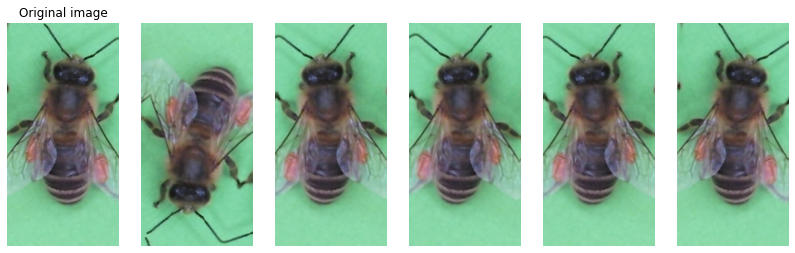

In [ ]:
utils.plot_augmentation_images(train_ds, augmentation_model)

# 3 - Two Step Attribute Prediction

In the beginning, you will follow a two-step approach to perform attribute prediction:
1. Feature extraction using a pre-trained ConvNet, followed by
2. training of an attribute prediction model based on the extracted features.

## 3.1 - Feature Extraction

**Task**: Complete the function `build_feature_extraction_model` for creating a feature extraction model based on the [`MobileNetV3Small`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small?hl=en) architecture. The resulting features shall be the **spatial averages** of the convolutional feature maps.
The feature extraction model shall encode each image into 576 features.

Make sure you
- used the MobileNet with `imagenet` weights,
- incorporated the `augmentation model`,
- freezed the `pre_trained_model`,
- pooled the spatial averages of the convolutional feature maps!


In [ ]:
# GRADED FUNCTION: build_feature_extraction_model (3 points)

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV3Small

def build_feature_extraction_model(input_shape, summary=True):
  
  ### START YOUR CODE HERE ###

#   model = Model(MobileNetV3Small(input_shape))
#   input_tensor = layers.Input(shape=input_shape)
#   model = MobileNetV3Small(input_shape=input_shape,weights='imagenet',input_tensor=input_tensor,include_top=False)
#   base_model = MobileNetV3Small(
#                   input_shape = input_shape,
#                   include_top = False,
#                   weights = 'imagenet'
#               )
#   base_model.trainable = False
#   input_tensor = layers.Input(shape=input_shape)
#   x = augmentation_model(input_tensor)
#   x = base_model(x, training = False)
#   x = tf.keras.layers.GlobalAveragePooling2D()(x)
#   # Dropout layer
#   x = tf.keras.layers.Dropout(0.2)(x)
#   # Dense layer
#   outputs = tf.keras.layers.Dense(576)(x)
#   # Final model
#   model = tf.keras.Model(input_tensor, outputs)
  
  
  # base_model = MobileNetV3Small(input_shape=input_shape, weights='imagenet', include_top=False)
  

  # # add a global spatial average pooling layer
  # x = base_model.output
  # x = layers.GlobalAveragePooling2D()(x)

  # # add a fully-connected layer
  # # x = layers.ActivityRegularizationDense(1024, activation='relu')(x)

  # # and a logistic layer
  # predictions = layers.Dense(576, activation='softmax')(x)

  # # this is the model we will train
  # model = Model(inputs=base_model.input, outputs=predictions)

  # # freeze the pre-trained model weights
  # for layer in base_model.layers:
  #     layer.trainable = False

  # # compile the model (should be done after setting layers to non-trainable)
  # model.compile(optimizer='rmsprop', loss='categorical_crossentropy')




  ### END YOUR CODE HERE ###
  ### START YOUR CODE HERE ###
  input_tensor = layers.Input(shape=input_shape)
  input_model = augmentation_model(input_tensor)
  base_model = MobileNetV3Small(
                  input_shape = input_shape,
                  include_top = False,
                  weights = 'imagenet',
                  dropout_rate = 0.5
              )
  base_model.trainable = False
  
  input_model = base_model(input_model, training = False)
  input_model = tf.keras.layers.GlobalAveragePooling2D()(input_model)
  
  # Dense layer
  outputs = tf.keras.layers.Dense(576)(input_model)
  # Final model
  model = tf.keras.Model(input_tensor, outputs)
  ### END YOUR CODE HERE ###

  if summary:
    print(model.summary())

  return model

feature_extraction_model = build_feature_extraction_model(INPUT_SHAPE, summary=False)

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
MobileNetV3Small??

In [ ]:
MobileNet??

Object `MobileNet` not found.


In [ ]:
feature_extraction_model??

In [ ]:
INPUT_SHAPE

(300, 150, 3)

In [ ]:
layers.SpatialDropout2D??

Next, forward the splits through the `feature_extraction_model` to get the features:

In [ ]:
# Note: feature extraction will take rougly a minute
X_train, Y_train = utils.extract_features(train_ds, feature_extraction_model, repetitions=5)
X_val, Y_val = utils.extract_features(val_ds, feature_extraction_model)
X_test, Y_test = utils.extract_features(test_ds, feature_extraction_model)

If everything was correct, you should have roughly 16k training samples, each with 576 features:

In [ ]:
print(X_train.shape)

(15785, 576)


## 3.2 - Predict Attributes Based on Features

Now create a model that predicts the four attributes based on the exracted features.

**Task**: Complete the function `build_prediction_model`. The model shall contain
- two hidden `Dense` layers of with `hidden_size` number of neurons,
- NO bias values in the hidden layers (you can remove the bias values with `use_bias=False`),
- batch normalization after each hidden layer, 
- ReLU activation after batch normalization,
- Dropout with 50% droprate before the output layer,
- output layer for attribute prediction across `NUMBER_OF_ATTRIBUTES` attributes and `OUTPUT_ACTIVATION` defined by you as activation function.

In [ ]:
# GRADED: build_prediction_model (3 points)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import *

def build_prediction_model(
    input_shape, 
    hidden_size, 
    init_lr=1e-3, 
    summary=True
  ):
  """Build and compile attribute prediction model based on extracted features.

  Args:
    input_shape (tuple): shape of input feature vector (not including the batch axis)
    hidden_size (int): number of neurons in hidden dense layers
    num_attributes (int): number of outputs (=number of neurons in output layer)
    init_lr (float): initial learning rate (default=1e-3)
    summary (bool): print model summary if `True` (default=True)

  Returns:
    tf.keras.Model: compiled model for attribute prediction
  """

  ### START YOUR CODE HERE ###

  model = Sequential()
  model.add(Dense(hidden_size, input_shape=input_shape, use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(hidden_size, use_bias=False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUMBER_OF_ATTRIBUTES, activation='sigmoid'))

  
  ### END YOUR CODE HERE ###
  
  model.compile(
      loss=LOSS_FUNCTION,
      optimizer=Adam(learning_rate=init_lr),
      metrics=['binary_accuracy']
  )

  if summary:
    print(model.summary())

  return model

In [ ]:
layers.Dense??

Now create an instance of your model:

In [ ]:
attr_prediction_model = build_prediction_model((X_train.shape[1],), 256)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               147456    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65536     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)              

Also write a helper function to create a list of callbacks for **learning rate scheduling** and **early stopping**.

**Task**: Complete the function `define_callbacks` to return following callbacks:
- A learning rate scheduler to reduce the learning rate by a factor of `0.1` if the `validation_loss` does not improve for `5` epochs. Set the `min_lr` to `1e-5` to end the training process if the learning rate becomes too small.
- An early stopping callback that ends the training process if the `validation_loss` does not improve for `10` epochs.

In [ ]:
# GRADED FUNCTION: define_callbacks (2 points)

def define_callbacks():
  ### START YOUR CODE HERE ###
  # lr_callback =  LearningRateScheduler(lambda e: 1e-2 * 0.9 ** e, verbose=1)
  lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, mode='min')
  stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
  ### END YOUR CODE HERE ###
  
  return [lr_callback, stop_callback]

Now train your model for 100 epochs:

In [ ]:
attr_prediction_model_history = attr_prediction_model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=define_callbacks()
)

Epoch 1/100
247/247 [==============================] - 2s 6ms/step - loss: 0.2102 - binary_accuracy: 0.9150 - val_loss: 0.6634 - val_binary_accuracy: 0.8513 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 1s 5ms/step - loss: 0.1181 - binary_accuracy: 0.9543 - val_loss: 9.7706 - val_binary_accuracy: 0.6478 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 1s 5ms/step - loss: 0.0925 - binary_accuracy: 0.9641 - val_loss: 15.5142 - val_binary_accuracy: 0.6756 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 1s 5ms/step - loss: 0.0722 - binary_accuracy: 0.9734 - val_loss: 7.9841 - val_binary_accuracy: 0.8513 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 1s 5ms/step - loss: 0.0616 - binary_accuracy: 0.9774 - val_loss: 26.2031 - val_binary_accuracy: 0.6850 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 1s 5ms/step - loss: 0.0487 - binary_accuracy: 0.9821 - val_loss: 34.8963 - val_binary_accurac

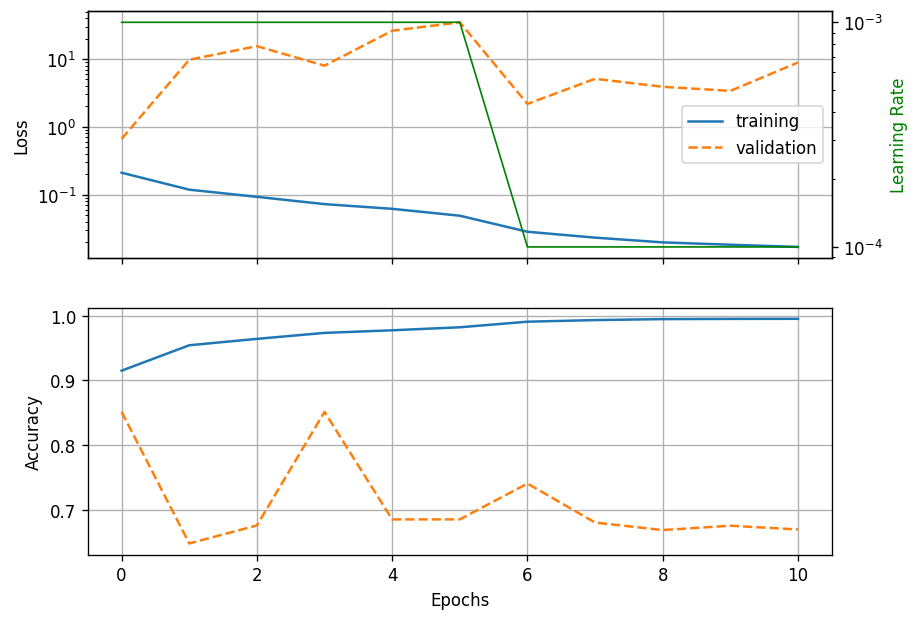

In [ ]:
utils.plot_history(attr_prediction_model_history)

It appears the model easily overfits on the training data. What a relief that you implemented early stopping! Let's see how your model performs on the test data:

In [ ]:
loss, accuracy = attr_prediction_model.evaluate(
    x=X_test,
    y=Y_test,
)
print(f'\nLoss: {loss:.2e}\nAccuracy: {100*accuracy:.1f}%')

24/24 [==============================] - 0s 3ms/step - loss: 0.6671 - binary_accuracy: 0.8495

Loss: 6.67e-01
Accuracy: 84.9%


So, the MobileNet features are somewhat useable, but it's hard for the model to find a more general solution. Let's see if your own ConvNet will be on par (or better) compared to the MobileNet.

# 4 - Attribute Prediction Using Your Own ConvNet

Instead of the two step approach using features extracted by a pre-trained model, you will now create your own ConvNet and train it from scratch.

**Task**: Complete the function `build_convnet`. The model architecture shall be as follows:
- Incorporate the `augmentation_model`.
- Use four convolution blocks with 
  - increasing amount of filters: `[32, 64, 128, 256]` (32 filters in the first block, ..., 256 filters in the fourth block),
  - 3x3 kernel size,
  - stride = 1,
  - no bias values for the kernels (you can remove the bias with `use_bias=False`),
  - spatial output size equal to the input size,
  - batch normalization after the convolution
  - ReLU activation after batch normalization
  - MaxPooling across 2x2 window
- Average pooling to compute the bottleneck presentation,
- Dropout with 50% droprate, 
- Output layer for **multi-label** attribute prediction.

In [ ]:
# GRADED FUNCTION: build_convnet (4 points)

def build_convnet(summary=True):

  ### START YOUR CODE HERE ###
  # model = Sequential()
  # model.add(Input(shape=INPUT_SHAPE))
  # model.add(layers.Conv2D(32, 3, use_bias=False))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(Conv2D(64, 3, use_bias=False))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(Conv2D(128, 3, use_bias=False))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(Conv2D(256, 3, use_bias=False))
  # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  # model.add(layers.MaxPooling2D((2, 2)))
  # model.add(layers.GlobalAveragePooling2D())
  # model.add(layers.Dropout(0.5))
  # model.add(layers.Flatten())
  # model.add(layers.Dense(NUMBER_OF_ATTRIBUTES, activation=OUTPUT_ACTIVATION))

  input_layer = Input(shape = INPUT_SHAPE)
  aug_model = augmentation_model(input_layer)
  conv_layer1 = layers.Conv2D(32, 3, use_bias=False)(aug_model)
  bn_layer1 = layers.BatchNormalization()(conv_layer1)
  relu_layer1 = layers.Activation('relu')(bn_layer1)
  pool1 = layers.MaxPooling2D()(relu_layer1)
  conv_layer2 = layers.Conv2D(64, 3, use_bias=False)(pool1)
  bn_layer2 = layers.BatchNormalization()(conv_layer2)
  relu_layer2 = layers.Activation('relu')(bn_layer2)
  pool2 = layers.MaxPooling2D()(relu_layer2)
  conv_layer3 = layers.Conv2D(128, 3, use_bias=False)(pool2)
  bn_layer3 = layers.BatchNormalization()(conv_layer3)
  relu_layer3 = layers.Activation('relu')(bn_layer3)
  pool3 = layers.MaxPooling2D()(relu_layer3)
  conv_layer4 = layers.Conv2D(256, 3, use_bias=False)(pool3)
  bn_layer4 = layers.BatchNormalization()(conv_layer4)
  relu_layer4 = layers.Activation('relu')(bn_layer4)
  pool4 = layers.MaxPooling2D()(relu_layer4)
  avg_pool = layers.GlobalAveragePooling2D()(pool4)
  dropout = layers.Dropout(0.5)(avg_pool)
  flatten = layers.Flatten()(dropout)
  output = layers.Dense(NUMBER_OF_ATTRIBUTES, activation=OUTPUT_ACTIVATION)(flatten)
  model = Model(input_layer, output)
  
  
  ### END YOUR CODE HERE ###
  
  if summary:
    print(model.summary())

  return model

my_convnet = build_convnet()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 148, 32)      864       
                                                                 
 batch_normalization_2 (Batc  (None, 298, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 298, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 74, 32)      0         
 )                                                         

In [ ]:
Conv2D??

To tackle the imbalanced class distribution, a weighted variant of the loss function is used: the loss for all attributes' labels is weighted by the respective frequency of occurence for the corresponding label.

Now compile and train the ConvNet:

In [ ]:
label_weights = utils.calculating_label_weights(utils.get_labels(train_ds))

my_convnet.compile(
    optimizer=Adam(learning_rate=3e-3),
    loss=utils.get_weighted_loss(label_weights),
    metrics=['binary_accuracy'],
)

my_convnet_history = my_convnet.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks = define_callbacks(),
    batch_size=BATCH_SIZE
)

Epoch 1/100
50/50 [==============================] - 15s 219ms/step - loss: 0.3355 - binary_accuracy: 0.8461 - val_loss: 1.7662 - val_binary_accuracy: 0.4895 - lr: 0.0030
Epoch 2/100
50/50 [==============================] - 9s 181ms/step - loss: 0.2097 - binary_accuracy: 0.9192 - val_loss: 4.1970 - val_binary_accuracy: 0.4898 - lr: 0.0030
Epoch 3/100
50/50 [==============================] - 9s 182ms/step - loss: 0.1578 - binary_accuracy: 0.9384 - val_loss: 3.3288 - val_binary_accuracy: 0.6756 - lr: 0.0030
Epoch 4/100
50/50 [==============================] - 9s 183ms/step - loss: 0.1467 - binary_accuracy: 0.9465 - val_loss: 3.1561 - val_binary_accuracy: 0.6756 - lr: 0.0030
Epoch 5/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1242 - binary_accuracy: 0.9557 - val_loss: 3.0476 - val_binary_accuracy: 0.6748 - lr: 0.0030
Epoch 6/100
50/50 [==============================] - 9s 184ms/step - loss: 0.1177 - binary_accuracy: 0.9574 - val_loss: 2.4816 - val_binary_accuracy:

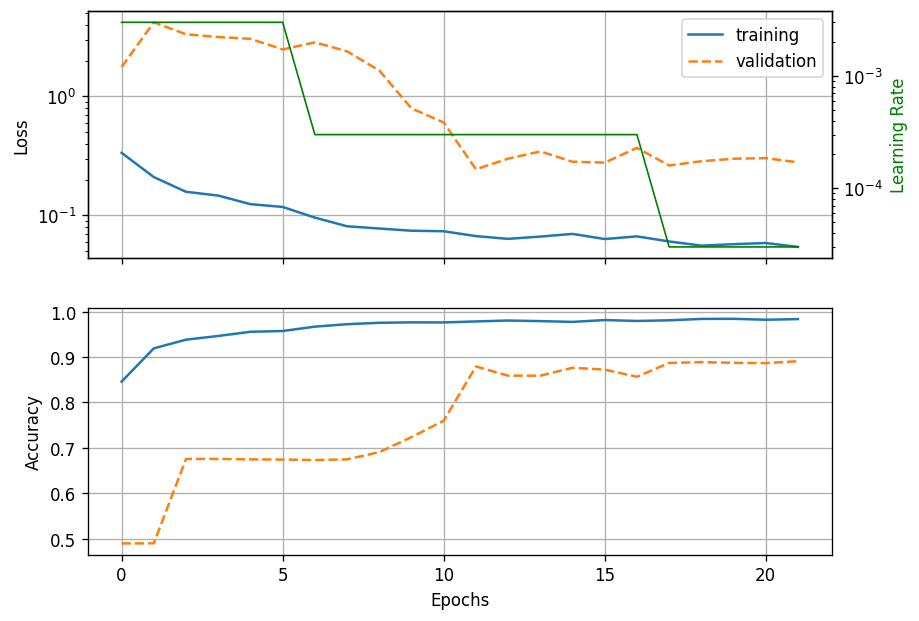

12/12 [==============================] - 1s 97ms/step - loss: 0.2418 - binary_accuracy: 0.8788

Loss: 2.42e-01
Accuracy: 87.9%


In [ ]:
utils.plot_history(my_convnet_history)

loss, accuracy = my_convnet.evaluate(test_ds)
print(f'\nLoss: {loss:.2e}\nAccuracy: {100*accuracy:.1f}%')

Your ConvNet should improve also on the validation data. However, there is still a notable gap between training and validation loss (and accuracy).

Let's take a look on the [confusion matrices](https://en.wikipedia.org/wiki/Confusion_matrix) to see where the model is making incorrect predictions on the test data:

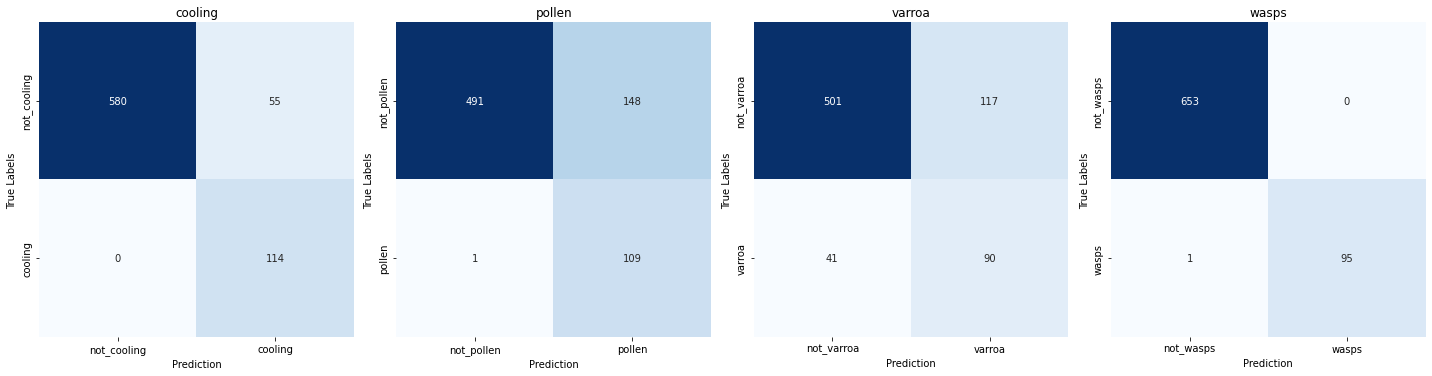

In [ ]:
utils.evaluate_confusion_matrices(test_ds, my_convnet)

Very likely, your network often predicts false positives for the pollen and varroa attributes...

# 5 - Class Activation Mapping

A simple approach for explaining ConvNet predictions is to localize the largest activations for a certain class (or attribute) in the last convolutional feature map. The feature maps are weighted by the dense layers weights and their sum is superimposed on the original input image. In result, this simple method allows for highlighting the image areas most relevant for a given prediction. The method is termed **class activation mapping** (CAM) and was originally proposed by [Bolei Zhou et al. in 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Zhou_Learning_Deep_Features_CVPR_2016_paper.html).

To compute class activation maps, you need the feature maps just before the GlobalPooling (GP) layer (either average or max pooling). Each element in the GP layer's output is the spatial average of one convolutional feature map. The relevance of the features (and thus the feature maps) for the predicted attributes are actually the weights of last dense layer that you have just trained! 

**TL;DR**: Using the weights of the output dense layer you can compute the weighted sum of the last convolutional feature maps to ultimately compute class activation maps.

**Task**: Complete the function `build_cam_model()` to convert a given `model` to a `cam_model`. As output, a `cam_model` shall return the last convolutional feature maps and the original output of the `model` (which are the prediction probabilities for the attributes). Make sure the outputs are defined in this order!

In [ ]:
# GRADED FUNCTION: build_cam_model (2 points)

def build_cam_model(model, layer_idx):
  """Converts a `model` to a CAM model. The outputs of a CAM model are the last 
  convolutional feature maps and the original model output (in that order!).

  Args:
    model (tf.keras.Model): A ConvNet with dense layer as output layer
    layer_idx (int): Index of the last layer before the GlobalPooling layer. 

  Returns:
    tf.keras.Model: The `model` converted to a CAM model
    tf.tensor: The weights of the output layer.
  """

  # get weights of the output layer
  weights,_ = model.layers[-1].get_weights()

  # define cam model
  ### START YOUR CODE HERE ###
  # cam_model =  tf.keras.applications.MobileNetV3Small(input_shape=INPUT_SHAPE,weights='imagenet')

  feature_maps = model.layers[layer_idx].output
  cam_model = tf.keras.Model(model.inputs, [feature_maps, model.output])
  
  # inputs = layers.Input(shape=(224, 224, 3))
  # outputs = model(inputs)
  # outputs = layers.GlobalAveragePooling2D()(outputs)
  # outputs = layers.Dense(NUMBER_OF_ATTRIBUTES, activation='softmax')(outputs)
  # outputs = model.layers[-1](NUMBER_OF_ATTRIBUTES, activation='softmax')(outputs)
  # cam_model = tf.keras.Model(inputs, outputs)

  ### END YOUR CODE HERE ###

  return cam_model, weights

In [ ]:
# Model.convert_mobilenet_v3_to_cam

In [ ]:
my_convnet.layers[len(my_convnet.layers)-4]

**Task:** Find out the index `layer_idx` of the last layer before the GP layer and convert `my_convnet` to a CAM model by executing `build_cam_model`:

In [ ]:
# GRADED: layer_idx (1 point)

### START YOUR CODE HERE ###
layer_idx = len(my_convnet.layers) - 5
### END YOUR CODE HERE ###

cam_model, cam_weights = build_cam_model(
    my_convnet,
    layer_idx=layer_idx
)

# Your model should have two outputs
for output in cam_model.output:
  print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 7, 256), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")


The function `compute_cam` takes your `cam_model` and the `cam_weights` to  compute the class activation map of a given input image `img`:

In [ ]:
from scipy.ndimage import zoom
from tensorflow.keras import backend as K

def compute_cam(img, cam_model, cam_weights, attribute_idx):
  """Compute class activation map to highlight activations for a given class 
  (or attribute) in an image.

  Args:
    img (tf.tensor): Input image of shape (height, width, 3)
    cam_model (tf.keras.Model): A cam_model that returns the last convolutional 
                                feature maps and the predictions
    cam_weights (tf.tensor): Weights of the output layer of the cam_model
    attribute_idx (int): Index of the class or attribute to be highlighted by CAM

  Returns:
    np.array: 2D class activation map normalized to [0, attribute probability]
    str: A string stating the highlighted attribute along with its prediction probability
  """
  
  # Prepend batch dimension to image
  img = K.expand_dims(img, 0)
  
  # Forward image through cam model
  feature_maps, attribute_predictions = cam_model.predict(img)

  # Remove preceeding batch dimension
  feature_maps = K.squeeze(feature_maps, axis=0)
  attribute_predictions = K.squeeze(attribute_predictions, axis=0)
  
  # Get the probability of the highlighted attribute
  attribute_probability = attribute_predictions.numpy()[attribute_idx]
  
  # Upsample feature maps to original image size
  feature_maps = zoom(
      feature_maps,
      (img.shape[1]/feature_maps.shape[0], img.shape[2]/feature_maps.shape[1], 1),
      order=1
  )
  
  # Compute weighted sum of activation maps for predicted class
  cam = np.dot( feature_maps, cam_weights[:, attribute_idx] )

  cam = np.zeros(dtype=np.float32, shape=feature_maps.shape[0:2])
  for i, w in enumerate(cam_weights[:, attribute_idx]):
    cam += w * feature_maps[:, :, i]

  # normalize cam to [0, attribute_probability]
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam *= attribute_predictions.numpy()[attribute_idx]

  # create a titlestring for the cam plot
  titlestr = f'{ATTRIBUTES[attribute_idx]}: {attribute_probability*100:.1f}%'

  return cam, titlestr

Let's print the four different attributes your model was trained to recognize:

In [ ]:
for idx, attr in enumerate(ATTRIBUTES):
  print(f'attr_idx={idx}: "{attr}"')

attr_idx=0: "cooling_output"
attr_idx=1: "pollen_output"
attr_idx=2: "varroa_output"
attr_idx=3: "wasps_output"


The `utils` provide the method `filter_for_samples_with_attribute` that returns samples of a dataset having a certain attribute as defined by it's index (see the printed list in the previous cell's output).

Here is an example: the attribute with index `2` corresponds to the attribute "varroa_output". Calling 

`varroa_samples = utils.filter_for_samples_with_attribute(test_ds, 2)`

stores all samples labeled positive for "varroa_output" in the array `varroa_samples`.


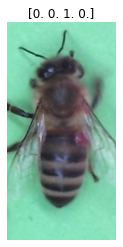

In [ ]:
from matplotlib import pyplot as plt

# Filter for samples labeled positive for "varroa_ouput" (attr_idx=2)
varroa_samples = utils.filter_for_samples_with_attribute(test_ds, 2)

# Get the first sample: store image in `img` and labels in `img_attributes`
img, img_attributes = varroa_samples[0]

# Plot the image
utils.plot_sample(img, img_attributes)

Let's compute the class activation map and plot it using `show_img_cam` provided in `utils`. The red image region should highlight the [Varroa mite](https://en.wikipedia.org/wiki/Varroa_destructor) in the image:

1/1 [==============================] - 0s 26ms/step


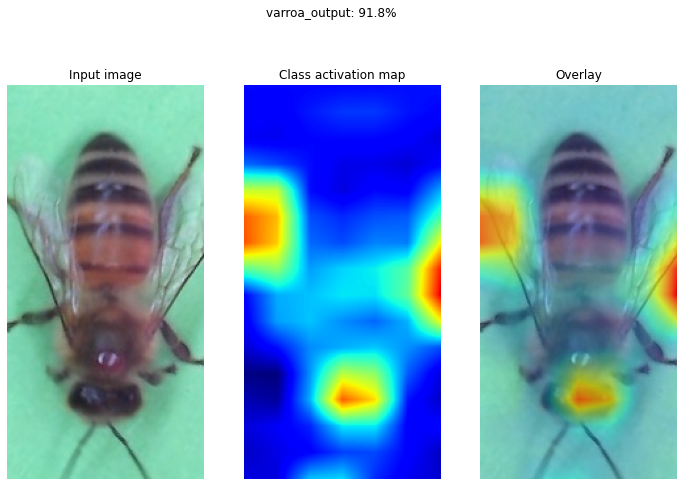

In [ ]:
# Compute the class activation map
img, _ = varroa_samples[1]
cam, titlestr = compute_cam(img, cam_model, cam_weights, attribute_idx=2)
utils.show_img_cam(img, cam, titlestr)

In conclusion, **class activation mapping** is a very simple method for explaining a neural networks output by localization of classification-relevant parts in the input images.

**Task**: Use the `utils.filter_for_samples_with_attribute`, `compute_cam`, and `utils.show_img_cam` methods to find one example for each remaining attribute and compute and plot the class activation maps for them.

In [ ]:
# GRADED: CAM for "cooling_output" sample (1 point)
# GRADED: CAM for "pollen_output" sample (1 point)
# GRADED: CAM for "wasp_output" sample (1 point)

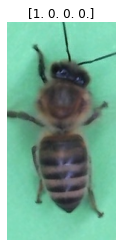

1/1 [==============================] - 0s 18ms/step


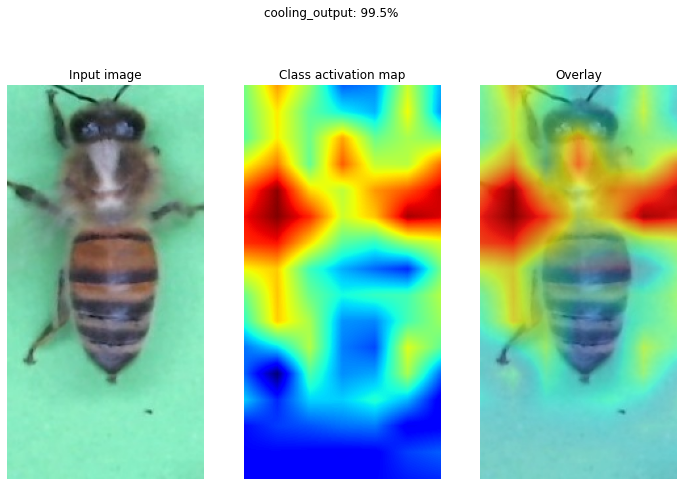

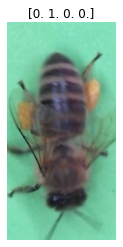

1/1 [==============================] - 0s 19ms/step


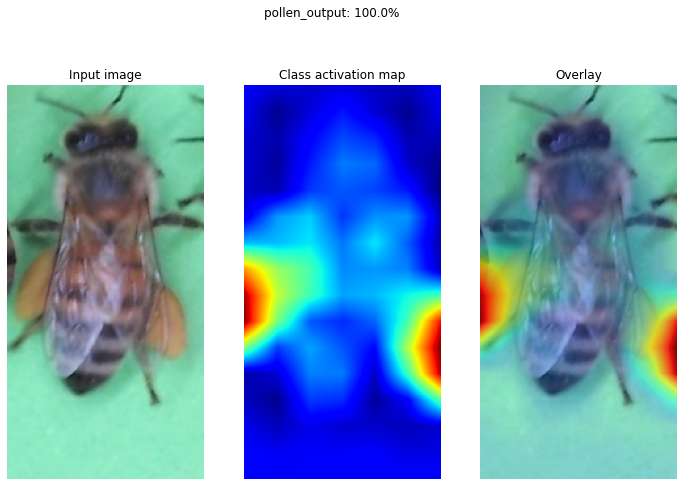

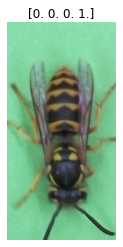

1/1 [==============================] - 0s 17ms/step


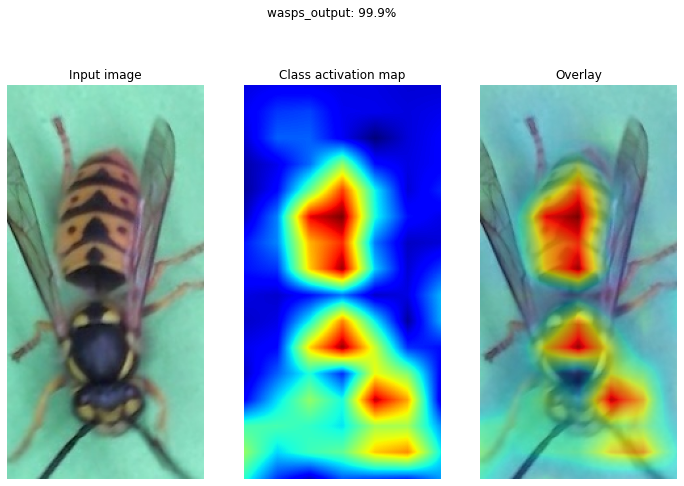

In [ ]:
cooling_samples = utils.filter_for_samples_with_attribute(test_ds, 0)
img, img_attributes = cooling_samples[0]
utils.plot_sample(img, img_attributes)
img, _ = cooling_samples[1]
cam, titlestr = compute_cam(img, cam_model, cam_weights, attribute_idx=0)
utils.show_img_cam(img, cam, titlestr)
# GRADED: CAM for "pollen_output" sample (1 point)
pollen_samples = utils.filter_for_samples_with_attribute(test_ds, 1)
img, img_attributes = pollen_samples[0]
utils.plot_sample(img, img_attributes)
img, _ = pollen_samples[1]
cam, titlestr = compute_cam(img, cam_model, cam_weights, attribute_idx=1)
utils.show_img_cam(img, cam, titlestr)
# GRADED: CAM for "wasp_output" sample (1 point)
wasp_samples = utils.filter_for_samples_with_attribute(test_ds, 3)
img, img_attributes = wasp_samples[0]
utils.plot_sample(img, img_attributes)
img, _ = wasp_samples[1]
cam, titlestr = compute_cam(img, cam_model, cam_weights, attribute_idx=3)
utils.show_img_cam(img, cam, titlestr)

---

# Congratulations on completing Assignment 2!

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as Jupyter notebook.
- Upload the downloaded Jupyter notebook to **Moodle**.